# Data Preparation Notebook

In [ ]:
!rm -rf ~/.cache/huggingface/datasets

In [1]:
from datasets import load_dataset

female_dataset = load_dataset("Nourhann/Arabic-Diacritized-TTS", cache_dir="./cache")
male_dataset = load_dataset("MBZUAI/ClArTTS", cache_dir="./cache")

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [2]:
print(male_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'file', 'audio', 'sampling_rate', 'duration'],
        num_rows: 9500
    })
    test: Dataset({
        features: ['text', 'file', 'audio', 'sampling_rate', 'duration'],
        num_rows: 205
    })
})


In [3]:
print(female_dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 8874
    })
})


In [4]:
import IPython.display as ipd

# Access the first sample in the train split
sampleM = male_dataset['train'][1000]
audio_array = sampleM['audio']
sampling_rate = sampleM['sampling_rate']
text = sampleM['text']
# Display the text
print(f"Text: {text}")

# Play the audio
ipd.Audio(audio_array, rate=sampling_rate)

Text: .عِيٌّ .وَإِكْثَارُ .يَجِب اخْتِيَارُ الْكَلَامِ


In [5]:
sampleM

{'text': '.عِيٌّ .وَإِكْثَارُ .يَجِب اخْتِيَارُ الْكَلَامِ',
 'file': 'ch_16_arabic_tts_dataset_367.wav',
 'audio': [0.001373291015625,
  0.001190185546875,
  0.0018310546875,
  0.00201416015625,
  0.001312255859375,
  0.000762939453125,
  0.00103759765625,
  0.0010986328125,
  0.00091552734375,
  0.000823974609375,
  0.001129150390625,
  0.0009765625,
  0.00152587890625,
  0.001861572265625,
  0.00164794921875,
  0.000885009765625,
  0.0003662109375,
  0.0008544921875,
  0.000762939453125,
  0.000732421875,
  0.0003662109375,
  0.000335693359375,
  0.000518798828125,
  0.000762939453125,
  0.000823974609375,
  0.000946044921875,
  0.0010986328125,
  0.000885009765625,
  0.00067138671875,
  0.00079345703125,
  0.000885009765625,
  0.000396728515625,
  0.000274658203125,
  0.0006103515625,
  0.000885009765625,
  0.000457763671875,
  0.00042724609375,
  0.000732421875,
  0.000457763671875,
  9.1552734375e-05,
  0.000335693359375,
  0.00067138671875,
  0.000579833984375,
  0.0003662109375

In [6]:
import IPython.display as ipd

# Access the first sample in the train split of female_dataset
sampleF = female_dataset['train'][4907]
audio_array = sampleF['audio']['array']
sampling_rate = sampleF['audio']['sampling_rate']
text = sampleF['transcription']
# Display the text
print(f"Text: {text}")

# Play the audio
ipd.Audio(audio_array, rate=sampling_rate)

Text: مُنْذُ وَلَدَتْهُ جَارَتُنَا مُنِيرَةٌ وَهُوَ لَا يَعْرِفُ مَكَانًا غَيْرَ بَيْتِنَا


In [7]:
sampleF

{'audio': {'path': None,
  'array': array([0.00094604, 0.0010376 , 0.0010376 , ..., 0.        , 0.        ,
         0.        ], shape=(113408,)),
  'sampling_rate': 22100},
 'transcription': 'مُنْذُ وَلَدَتْهُ جَارَتُنَا مُنِيرَةٌ وَهُوَ لَا يَعْرِفُ مَكَانًا غَيْرَ بَيْتِنَا'}

## Dataset Alignment (Male + Female)

### Female metadata Extraction

In [ ]:
import pandas as pd
from tqdm import tqdm

# Combine splits into a single DataFrame with a 'split' column
female_records = []
for split in female_dataset.keys():
    for idx, sample in enumerate(tqdm(female_dataset[split], desc=f"Processing {split} split")):
        file_path = sample["audio"].get("path")
        if file_path is None:
            file_path = f"female_{idx+1:04d}"
        female_records.append({
            "text": sample["transcription"],
            "file": file_path,
            "sampling_rate": sample["audio"]["sampling_rate"],
            "duration": round(len(sample["audio"]["array"]) / sample["audio"]["sampling_rate"], 2),
            "split": split
        })

female_df = pd.DataFrame(female_records)
female_df.head()

Processing train split: 100%|██████████| 8874/8874 [01:15<00:00, 118.19it/s]


,text,file,sampling_rate,duration,split
0,اَللّـهُمَّ ما قُلْتُ فى جُمُعَتى هذِهِ مِنْ ...,female_0001,22100,27.974661,train
1,اَللّـهُمَّ ما قُلْتُ فى جُمُعَتى هذِهِ مِنْ ...,female_0002,22100,27.974661,train
2,اَللّـهُمَّ ما قُلْتُ فى جُمُعَتى هذِهِ مِنْ ...,female_0003,22100,27.417828,train
3,اَللّـهُمَّ اِنّى تَعَمَّدْتُ اِلَيْكَ بِحاجَ...,female_0004,22100,44.251674,train
4,لا اِلـهَ إلاّ اللهُ وَاللهُ اَكْبَرُ وَسُبْح...,female_0005,22100,59.576923,train


In [10]:
# Save female metadata to CSV
female_df.to_csv("female_metadata.csv", index=False)

### Male metadata Extraction

In [8]:
import pandas as pd
from tqdm import tqdm

male_dfs = []
total = sum(len(male_dataset[split]) for split in male_dataset.keys())
with tqdm(total=total, desc="Processing all male samples") as pbar:
    for split in male_dataset.keys():
        df = male_dataset[split].to_pandas()
        df["original_file"] = df["file"].str.split('.').str[0]
        df["file"] = [f"male_{i+1:04d}" for i in range(len(df))]
        df["split"] = split
        male_dfs.append(df[["text", "file", "original_file", "sampling_rate", "duration", "split"]])
        pbar.update(len(df))

male_df = pd.concat(male_dfs, ignore_index=True)
male_df.head()

Processing all male samples: 100%|██████████| 9705/9705 [02:18<00:00, 70.19it/s]


,text,file,original_file,sampling_rate,duration,split
0,.لِأَنَّهُ لَا يَرَى أَنَّهُ عَلَى السَّفَهِ ....,male_0001,ch_20_arabic_tts_dataset_48,40100,5.29,train
1,.الْعُمْرُ .يَنْقُصُ وَالذُّنُوبُ تَزِيدُ,male_0002,ch_05_arabic_tts_dataset_436,40100,3.06,train
2,.قَلِيلَةً بَيْنَ الْمُكْثِرِينَ .فَإِنَّ النَ...,male_0003,ch_20_arabic_tts_dataset_20,40100,3.32,train
3,.إلَّا تَفَضُّلَا .وَمِنْهَا: الْعَقْلُ .الَّذ...,male_0004,ch_16_arabic_tts_dataset_112,40100,5.08,train
4,.إلَّا مَثَلٌ مَرْذُولٌ .وَتَشْبِيهٌ .مَعْلُولٌ,male_0005,ch_16_arabic_tts_dataset_554,40100,3.48,train


In [22]:
# Save male metadata to CSV
male_df.to_csv("male_metadata.csv", index=False)

## Saving the WAV files for StyleTTS2

In [10]:
import os

output_dir = "wav_data"
os.makedirs(output_dir, exist_ok=True)
target_sr = 24000

### Female WAV files

In [ ]:

import numpy as np
import soundfile as sf
from scipy.signal import resample
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm


def save_resampled_female_wav(row):
    idx = row.name  # row.name gives the DataFrame index
    split = row["split"]
    sample = female_dataset[split][idx]
    audio_array = sample["audio"]["array"]
    orig_sr = sample["audio"]["sampling_rate"]

    # Resample if needed
    if orig_sr != target_sr:
        num_samples = int(len(audio_array) * target_sr / orig_sr)
        audio_array = resample(audio_array, num_samples)
    
    out_path = os.path.join(output_dir, f"{row['file']}.wav")
    sf.write(out_path, audio_array, target_sr)
    return out_path

max_workers = os.cpu_count() or 4

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for idx, row in female_df.iterrows():
        futures.append(executor.submit(save_resampled_female_wav, row))
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Saving resampled female wavs"):
        pass

Saving resampled female wavs: 100%|██████████| 8874/8874 [07:18<00:00, 20.23it/s]  


### Male WAV files

In [ ]:
import numpy as np
import soundfile as sf
from scipy.signal import resample
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm


def save_resampled_male_wav(row):
    split = row["split"]
    sample_idx = int(row["file"].split("_")[1]) - 1  # e.g., "male_0001" -> 0
    sample = male_dataset[split][sample_idx]
    audio_array = sample["audio"]
    orig_sr = sample["sampling_rate"]

    # Resample if needed
    if orig_sr != target_sr:
        num_samples = int(len(audio_array) * target_sr / orig_sr)
        audio_array = resample(audio_array, num_samples)
    
    # Save using the original_file column as filename
    out_path = os.path.join(output_dir, f"{row['original_file']}.wav")
    sf.write(out_path, audio_array, target_sr)
    return out_path

max_workers = os.cpu_count() or 4

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for idx, row in male_df.iterrows():
        futures.append(executor.submit(save_resampled_male_wav, row))
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Saving resampled male wavs"):
        pass

Saving resampled male wavs: 100%|██████████| 9705/9705 [10:26<00:00, 15.49it/s]


## Dataset Analysis

In [11]:
# Find the duration statistics for both datasets

print("Female dataset duration statistics:")
print(female_df["duration"].describe())

print("\nMale dataset duration statistics:")
print(male_df["duration"].describe())

Female dataset duration statistics:
count    8874.000000
mean       15.913158
std        23.362292
min         0.530000
25%         3.680000
50%         8.070000
75%        18.310000
max       372.980000
Name: duration, dtype: float64

Male dataset duration statistics:
count    9705.000000
mean        4.230412
std         1.000240
min         1.790000
25%         3.470000
50%         4.010000
75%         4.750000
max        12.780000
Name: duration, dtype: float64


In [12]:
# Count the files in each dataset having a duration greater than 10 seconds

female_long = (female_df["duration"] > 10).sum()
male_long = (male_df["duration"] > 10).sum()

print(f"Female files > 10 seconds: {female_long}")
print(f"Male files > 10 seconds: {male_long}")

Female files > 10 seconds: 3783
Male files > 10 seconds: 12


In [13]:
import requests

# API endpoint
api_url = "https://api.genderrecognition.com/v1/voice-gender-recognition/api"

# API key
api_key = '78765665efa44c5d138a8d1d1b7bace07206f93442e8da92395d32c3775e2ea4'

# File path to the .wav file
file_path = os.path.join(output_dir, "female_0001.wav")  # Ensure the file is in .wav format

# Open the file and send the request
try:
    with open(file_path, 'rb') as file:
        files = {"file": ("recording.wav", file, "audio/wav")}
        headers = {"apiKey": api_key}
        response = requests.post(api_url, files=files, headers=headers)

    # Check response status
    if response.status_code == 200:
        print("API Response:", response.json())
    else:
        print(f"Request failed with status code {response.status_code}: {response.text}")

except FileNotFoundError:
    print(f"File not found: {file_path}")
except requests.RequestException as e:
    print(f"Error making request: {e}")


API Response: {'gender': 'female'}


In [ ]:
import requests
import os
import pandas as pd

# API endpoint and key
api_url = "https://api.genderrecognition.com/v1/voice-gender-recognition/api"
api_key = '78765665efa44c5d138a8d1d1b7bace07206f93442e8da92395d32c3775e2ea4'

# Collect all female wav files
female_wav_files = sorted(
    [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.startswith("female_") and f.endswith(".wav")]
)

# Try to load existing results to resume
csv_path = "female_gender_api_results.csv"
if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)
    done_files = set(existing_df['file'])
    results = existing_df.to_dict('records')
    print(f"Resuming: {len(done_files)} files already processed.")
else:
    done_files = set()
    results = []

batch_size = 50  # Save after every 50 files

for idx, file_path in enumerate(female_wav_files):
    file_name = os.path.basename(file_path)
    if file_name in done_files:
        continue  # Skip already processed files

    try:
        with open(file_path, 'rb') as file:
            files = {"file": ("recording.wav", file, "audio/wav")}
            headers = {"apiKey": api_key}
            response = requests.post(api_url, files=files, headers=headers)

        if response.status_code == 200:
            result = response.json()
            print(f"{file_name}: {result}")
            results.append({"file": file_name, "gender": result.get("gender", None)})
        else:
            print(f"{file_name}: Request failed with status code {response.status_code}: {response.text}")
            results.append({"file": file_name, "gender": None, "error": response.text})
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        results.append({"file": file_name, "gender": None, "error": "File not found"})
    except requests.RequestException as e:
        print(f"Error making request for {file_path}: {e}")
        results.append({"file": file_name, "gender": None, "error": str(e)})

    # Save progress every batch_size files
    if (len(results) % batch_size == 0) or (idx == len(female_wav_files) - 1):
        pd.DataFrame(results).to_csv(csv_path, index=False)
        print(f"Progress saved after {len(results)} files.")

print("Processing complete.")

female_0001.wav: {'gender': 'female'}
female_0002.wav: {'gender': 'female'}
female_0003.wav: {'gender': 'female'}
female_0004.wav: {'gender': 'female'}
female_0005.wav: {'gender': 'female'}
female_0006.wav: {'gender': 'female'}
female_0007.wav: {'gender': 'female'}


In [11]:
# Define AudeeringModel (gender part only)
import numpy as np
import torch
import torch.nn as nn
import librosa
from transformers import Wav2Vec2Processor
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2Model, Wav2Vec2PreTrainedModel

class ModelHead(nn.Module):
    def __init__(self, config, num_labels):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class AgeGenderModel(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.wav2vec2 = Wav2Vec2Model(config)
        self.age = ModelHead(config, 1)
        self.gender = ModelHead(config, 3)
        self.init_weights()

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs[0]
        hidden_states = torch.mean(hidden_states, dim=1)
        logits_age = self.age.forward(hidden_states)
        logits_gender = torch.softmax(self.gender.forward(hidden_states), dim=1)
        return hidden_states, logits_age, logits_gender

class AudeeringModel(object):
    def __init__(self, model_path: str):
        self.model_path = model_path
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        processor = Wav2Vec2Processor.from_pretrained(self.model_path)
        model = AgeGenderModel.from_pretrained(self.model_path).to(device)
        model.eval()
        self.device = device
        self.processor = processor
        self.model = model

    def predict(self, signal: np.ndarray, sample_rate: int) -> dict:
        y = self.processor(signal, sampling_rate=sample_rate)
        y = y["input_values"][0]
        y = y.reshape(1, -1)
        y = torch.from_numpy(y).to(self.device)
        _, _, gender = self.model.forward(y)
        gender = gender.detach().cpu().numpy().tolist()[0]
        result = {
            "female": round(gender[0], 4),
            "male": round(gender[1], 4),
            "child": round(gender[2], 4),
        }
        return result

    def __call__(self, *args, **kwargs):
        return self.predict(*args, **kwargs)

In [12]:
import os
import json
import time
import librosa
import pandas as pd

# Model setup
model_path = "audeering/wav2vec2-large-robust-6-ft-age-gender"
sample_rate = 16000
infer_engine = AudeeringModel(model_path=model_path)

output_dir = "wav_data"
output_csv = "female_gender_probs_audeering.csv"

# Set this to a file path to test a single file, or None to process all
test_file = None
# Example: 
# test_file = "wav_data/female_4806.wav"

if test_file is not None:
    files_to_process = [test_file]
else:
    files_to_process = sorted(
        [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.startswith("female_") and f.endswith(".wav")]
    )

results = []
batch_size = 20

for idx, file_path in enumerate(files_to_process):
    try:
        # Load and resample audio
        signal, _ = librosa.load(file_path, sr=sample_rate)
        # Only gender part
        gender_probs = infer_engine(signal, sample_rate)
        gender_only = {
            "female": gender_probs["female"],
            "male": gender_probs["male"],
            "child": gender_probs["child"],
        }
        print(f"{os.path.basename(file_path)}: {gender_only}")
        results.append({"file": os.path.basename(file_path), **gender_only})
    except Exception as e:
        print(f"Error for {file_path}: {e}")
        results.append({"file": os.path.basename(file_path), "female": None, "male": None, "child": None, "error": str(e)})

    # Save progress every batch_size files or at the end
    if (len(results) % batch_size == 0) or (idx == len(files_to_process) - 1):
        pd.DataFrame(results).to_csv(output_csv, index=False)
        print(f"Progress saved after {len(results)} files.")

print("Processing complete.")

female_0001.wav: {'female': 0.9939, 'male': 0.0059, 'child': 0.0002}
female_0002.wav: {'female': 0.9939, 'male': 0.0059, 'child': 0.0002}
female_0003.wav: {'female': 0.9809, 'male': 0.0189, 'child': 0.0001}
female_0004.wav: {'female': 0.986, 'male': 0.0138, 'child': 0.0001}
female_0005.wav: {'female': 0.9953, 'male': 0.0047, 'child': 0.0}


KeyboardInterrupt: 

In [ ]:
import os
import librosa
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import Wav2Vec2Processor
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2Model, Wav2Vec2PreTrainedModel

# ----------------------
# SETUP CONFIGURATION
# ----------------------
MODEL_PATH = "audeering/wav2vec2-large-robust-6-ft-age-gender"
SAMPLE_RATE = 16000
AUDIO_DIR = "wav_data"
OUTPUT_CSV = "gender_predictions.csv"
BATCH_SIZE = 8  # GPU is optimized for batch inference
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ----------------------
# MODEL DEFINITION
# ----------------------


class ModelHead(torch.nn.Module):
    """Classification Head for Gender and Age Prediction."""
    def __init__(self, config, num_labels):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = torch.nn.Dropout(config.final_dropout)
        self.out_proj = torch.nn.Linear(config.hidden_size, num_labels)

    def forward(self, features):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class AgeGenderModel(Wav2Vec2PreTrainedModel):
    """Custom Model for Age & Gender Classification."""
    def __init__(self, config):
        super().__init__(config)
        self.wav2vec2 = Wav2Vec2Model(config)
        self.age = ModelHead(config, 1)
        self.gender = ModelHead(config, 3)
        self.init_weights()

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = torch.mean(outputs[0], dim=1)

        logits_age = self.age(hidden_states)
        logits_gender = torch.softmax(self.gender(hidden_states), dim=1)

        return hidden_states, logits_age, logits_gender

class AudeeringModel:
    """Wrapper for Loading & Running Inference with Audeering Gender Model."""
    def __init__(self, model_path: str, device=DEVICE):
        self.device = device
        self.processor = Wav2Vec2Processor.from_pretrained(model_path)
        self.model = AgeGenderModel.from_pretrained(model_path).to(self.device)
        self.model.eval()

    def predict_batch(self, signals, sample_rate: int) -> list:
        # Convert signals tensor to list of numpy arrays
        if isinstance(signals, torch.Tensor):
            signals = [s.cpu().numpy() for s in signals]
        processed_batch = self.processor(signals, sampling_rate=sample_rate, return_tensors="pt", padding=True)
        input_values = processed_batch["input_values"].to(self.device)

        # Run batched inference
        _, _, gender_logits = self.model(input_values)
        gender_scores = gender_logits.detach().cpu().numpy()

        results = []
        for scores in gender_scores:
            results.append({
                "female": round(scores[0], 4),
                "male": round(scores[1], 4),
                "child": round(scores[2], 4),
            })

        return results

# ----------------------
# CUSTOM DATASET + DATALOADER
# ----------------------

def collate_fn(batch):
    file_paths, signals = zip(*batch)
    max_len = max([len(s) for s in signals])
    padded_signals = []
    for s in signals:
        if len(s) < max_len:
            padded = np.pad(s, (0, max_len - len(s)), mode='constant')
        else:
            padded = s
        padded_signals.append(padded)
    signals_tensor = torch.tensor(padded_signals, dtype=torch.float32)  # shape: [batch, max_len]
    return list(file_paths), signals_tensor

class AudioDataset(Dataset):
    """Custom PyTorch Dataset to Load & Process Audio Files."""
    def __init__(self, file_paths, sample_rate):
        self.file_paths = file_paths
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        signal, _ = librosa.load(file_path, sr=self.sample_rate)
        return file_path, signal

# ----------------------
# BATCH INFERENCE EXECUTION
# ----------------------

def process_all_files(audio_dir, model, output_csv):
    """Run batched gender classification on 'female_df' WAV files."""
    files_to_process = sorted(
        [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.startswith("female_") and f.endswith(".wav")]
    )

    # Load dataset & create DataLoader
    dataset = AudioDataset(files_to_process, SAMPLE_RATE)
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    results = []
    
    for batch in tqdm(data_loader, desc="Processing batches"):
        file_paths, signals = batch
        try:
            # Try on GPU
            gender_probs = model.predict_batch(signals, SAMPLE_RATE)
        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print(f"CUDA OOM on batch with files: {[os.path.basename(f) for f in file_paths]}")
                torch.cuda.empty_cache()
                # Move model to CPU
                model.model = model.model.cpu()
                model.device = torch.device("cpu")
                # Re-run on CPU
                gender_probs = model.predict_batch(signals, SAMPLE_RATE)
                # Move model back to GPU for next batch
                model.model = model.model.to(DEVICE)
                model.device = DEVICE
            else:
                raise  # re-raise other errors

        for file_path, probs in zip(file_paths, gender_probs):
            results.append({"file": os.path.basename(file_path), **probs})

    # Save all results to CSV
    pd.DataFrame(results).to_csv(output_csv, index=False)
    print(f"Processing complete. Results saved to {output_csv}")

# ----------------------
# EXECUTE IN JUPYTER NOTEBOOK
# ----------------------

# Initialize model
print("Loading Model...")
model = AudeeringModel(MODEL_PATH, device=DEVICE)

# Run batch processing in Jupyter
print("Processing WAV files in batches...")
process_all_files(AUDIO_DIR, model, OUTPUT_CSV)

Loading Model...
Processing WAV files in batches...


Processing batches:   0%|          | 0/1110 [00:00<?, ?it/s]

CUDA OOM on batch with files: ['female_0001.wav', 'female_0002.wav', 'female_0003.wav', 'female_0004.wav', 'female_0005.wav', 'female_0006.wav', 'female_0007.wav', 'female_0008.wav']


## Gender Classification Results Analysis

In [14]:
import pandas as pd

df_online = pd.read_csv("female_gender_api_results.csv")
print(df_online["gender"].value_counts())

gender
female    4960
male      3914
Name: count, dtype: int64


In [15]:
import pandas as pd

df_local = pd.read_csv('female_gender_probs_audeering.csv')

# Add predicted column using all three probability columns
df_local['predicted'] = df_local[['female', 'male', 'child']].idxmax(axis=1)

print(df_local['predicted'].value_counts())

predicted
female    4960
male      3914
Name: count, dtype: int64


In [16]:
# Match the results of df_online and df_local

# Ensure both dataframes are loaded
# df_online: file, gender (from API)
# df_local: file, female, male, child, predicted (from local model)

# Merge on 'file' column
merged = pd.merge(df_online, df_local, on="file", suffixes=('_api', '_local'))

# Compare API gender with local predicted
merged['match'] = merged['gender'] == merged['predicted']

# Print overall agreement
print("Agreement count:", merged['match'].sum())
print("Total compared:", len(merged))
print("Agreement ratio:", merged['match'].mean())

# Show confusion matrix
confusion = pd.crosstab(merged['gender'], merged['predicted'], rownames=['API'], colnames=['Local'])
print(confusion)

Agreement count: 8872
Total compared: 8874
Agreement ratio: 0.9997746224926752
Local   female  male
API                 
female    4959     1
male         1  3913


In [17]:
# Get the names of files where API and local prediction did not match,
# and display both predictions
not_matched = merged.loc[~merged['match'], ['file', 'gender', 'predicted']]
print("Files with mismatched gender prediction (file, API, local):")
for fname, api_pred, local_pred in zip(not_matched['file'], not_matched['gender'], not_matched['predicted']):
    print(f"{fname}: API={api_pred}, Local={local_pred}")

Files with mismatched gender prediction (file, API, local):
female_3848.wav: API=female, Local=male
female_8874.wav: API=male, Local=female


In [18]:
# Filter files where both models agree
agreed = merged[merged['match']]

# Get lists of agreed female and male files
agreed_female_files = set(agreed.loc[agreed['gender'] == 'female', 'file'])
agreed_male_files = set(agreed.loc[agreed['gender'] == 'male', 'file'])

# Filter female_df for agreed female and male files
female_df_agreed_female = female_df[female_df['file'].apply(lambda x: f"{x}.wav" in agreed_female_files)]
female_df_agreed_male = female_df[female_df['file'].apply(lambda x: f"{x}.wav" in agreed_male_files)]

print(f"Agreed female files: {len(female_df_agreed_female)}")
print(f"Agreed male files: {len(female_df_agreed_male)}")

Agreed female files: 4959
Agreed male files: 3913


## Duration Statistics

### Female Data Analysis

In [19]:
female_df_agreed_female.describe()

,sampling_rate,duration
count,4959.0,4959.000000
mean,22100.0,22.196288
std,0.0,27.931925
min,22100.0,0.590000
25%,22100.0,6.490000
50%,22100.0,13.580000
75%,22100.0,28.315000
max,22100.0,372.980000


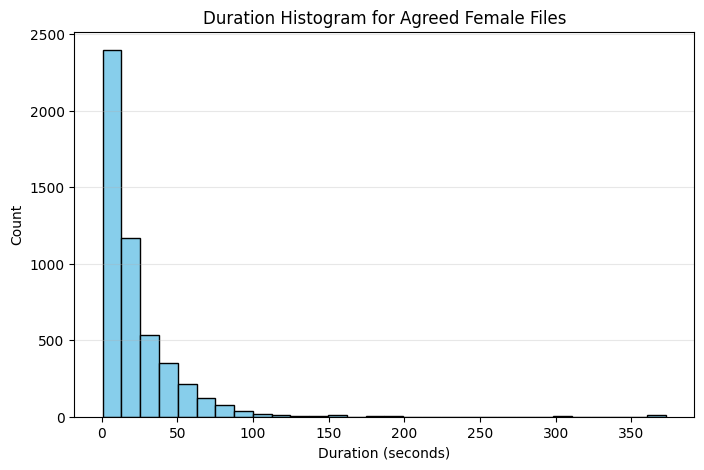

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(female_df_agreed_female['duration'], bins=30, color='skyblue', edgecolor='black')
plt.title('Duration Histogram for Agreed Female Files')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

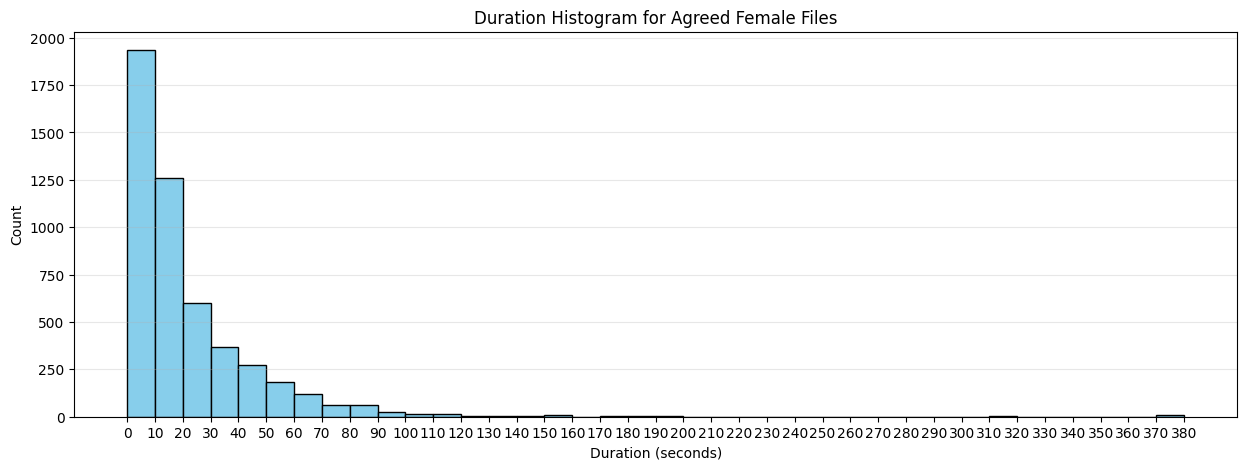

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define bin edges: 0-10, 10-20, ..., up to the max duration (rounded up to next 10)
max_duration = np.ceil(female_df_agreed_female['duration'].max() / 10) * 10
bins = np.arange(0, max_duration + 10, 10)

plt.figure(figsize=(15, 5))
plt.hist(female_df_agreed_female['duration'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Duration Histogram for Agreed Female Files')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.xticks(bins)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [22]:
# Count files in 0-10 seconds range and sum their total duration
mask_0_10 = (female_df_agreed_female['duration'] > 0) & (female_df_agreed_female['duration'] <= 10)
count_0_10 = mask_0_10.sum()
total_duration_0_10 = female_df_agreed_female.loc[mask_0_10, 'duration'].sum()

print(f"Number of agreed female files with duration 0-10 seconds: {count_0_10}")
print(f"Total duration of these files: {total_duration_0_10/3600:.2f} hrs")

Number of agreed female files with duration 0-10 seconds: 1936
Total duration of these files: 2.92 hrs


In [23]:
# Count files in 0-20 seconds range and sum their total duration
mask_0_20 = (female_df_agreed_female['duration'] > 0) & (female_df_agreed_female['duration'] <= 20)
count_0_20 = mask_0_20.sum()
total_duration_0_20 = female_df_agreed_female.loc[mask_0_20, 'duration'].sum()

print(f"Number of agreed female files with duration 0-20 seconds: {count_0_20}")
print(f"Total duration of these files: {total_duration_0_20/3600:.2f} hrs")

Number of agreed female files with duration 0-20 seconds: 3195
Total duration of these files: 7.94 hrs


In [24]:
female_df_temp = female_df_agreed_female[mask_0_20].copy()
female_df_temp.reset_index(drop=True, inplace=True)
female_df_temp

,text,file,sampling_rate,duration,split
0,فَقَالَ لَهُ إِعْمَلْ ياَ أَخِي فيِ صَنْعَةِ ...,female_0009,22100,5.91,train
1,وَسَكَتَتِ اۘلأُمُّ بَعْدَ أَنْ أَفْرَغَتْ مَ...,female_0012,22100,13.91,train
2,فَقَالَ لَهُ إِعْمَلْ ياَ أَخِي فيِ صَنْعَةِ ...,female_0015,22100,6.01,train
3,وَسَكَتَتِ اۘلأُمُّ بَعْدَ أَنْ أَفْرَغَتْ مَ...,female_0017,22100,14.28,train
4,فَقَالَ لَهُ إِعْمَلْ ياَ أَخِي فيِ صَنْعَةِ ...,female_0025,22100,5.91,train
...,...,...,...,...,...
3190,وَالْحَيَاةُ قَدْ جَعَلَتِ الْإِنْسَانَ وَحْد...,female_8855,22100,7.01,train
3191,وَالْحَيَاةُ تُلَوِّنُ عَيْنَيِ الطِّفْلِ وَت...,female_8857,22100,9.88,train
3192,"ضَوْءٌ, دَفْتَرٌ, ضَحِكٌ, دَوَاءٌ, مَضْرَبٌ, د...",female_8868,22100,9.27,train
3193,"ضَوْءٌ, دَفْتَرٌ, ضَحِكٌ, دَوَاءٌ, مَضْرَبٌ, د...",female_8870,22100,18.82,train


In [25]:
# Split female_df_final into train and test using sklearn's train_test_split
from sklearn.model_selection import train_test_split

# Set your desired test size (e.g., 20%)
female_df_train, female_df_test = train_test_split(
    female_df_temp, test_size=0.02, random_state=42, shuffle=True
)

# Reset indices
female_df_train = female_df_train.reset_index(drop=True)
female_df_test = female_df_test.reset_index(drop=True)

female_df_test['split'] = 'test'

print(f"female_df_train shape: {female_df_train.shape}")
print(f"female_df_test shape: {female_df_test.shape}")

# Print total duration for train and test sets
print("Train set total duration (hours):", female_df_train['duration'].sum() / 3600)
print("Test set total duration (hours):", female_df_test['duration'].sum() / 3600)

female_df_train shape: (3131, 5)
female_df_test shape: (64, 5)
Train set total duration (hours): 7.762580555555556
Test set total duration (hours): 0.18175555555555556


In [26]:
# Combine train and test splits for female data so that test files are at the end
female_df_final = pd.concat([female_df_train, female_df_test], ignore_index=True)
female_df_final.reset_index(drop=True, inplace=True)

female_df_final

,text,file,sampling_rate,duration,split
0,سُورَةُ الْأَحْزَابِ، الْآيَةُ,female_6397,22100,2.80,train
1,يَكُنْ قَدْ وَضَعَ حَدًّا لَهُ، بَلْ حَضَّ عَ...,female_8562,22100,11.03,train
2,وَلَمْ يَكُنْ الْمَسْعُودِيُّ وَاهِمًا فَذَاك...,female_0811,22100,6.50,train
3,وَمِنْ هَذِهِ الإمبراطورية أَقَالِيمُ أَصْبَح...,female_0767,22100,13.22,train
4,وَأَمَّا أَهْلُ الْمَقْتِ فَيُنَادَوْنَ عَلَى...,female_6439,22100,16.43,train
...,...,...,...,...,...
3190,وَقَوْلُهُ تَعَالَى وَإِنَّ لَكُمْ فِي الْأَن...,female_6682,22100,12.26,test
3191,وَهُوَ وَادٍ فَحْلٌ مِنْ أَوْدِيَةِ الْحِجَاز...,female_0960,22100,9.95,test
3192,وَهَذِهِ صِفَةٌ عَظِيمَةٌ فِي الثّباتِ وَالطّ...,female_2156,22100,11.06,test
3193,قُلْت يُعْرَفُ الْيَوْمَ بِأُجَيْرِدٍ تَصْغِي...,female_1176,22100,15.93,test


### Male Data Analysis

In [28]:
# Extract rows from male_df where split is 'train'
male_df_train = male_df[male_df['split'] == 'train']
male_df_test  = male_df[male_df['split'] == 'test']


male_df_train.describe()

,sampling_rate,duration
count,9500.0,9500.000000
mean,40100.0,4.228651
std,0.0,0.999455
min,40100.0,1.790000
25%,40100.0,3.470000
50%,40100.0,4.000000
75%,40100.0,4.750000
max,40100.0,12.780000


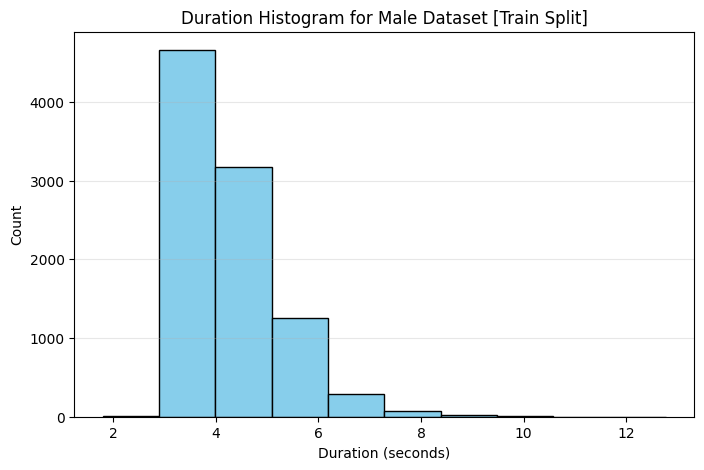

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(male_df_train['duration'], bins=10, color='skyblue', edgecolor='black')
plt.title('Duration Histogram for Male Dataset [Train Split]')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

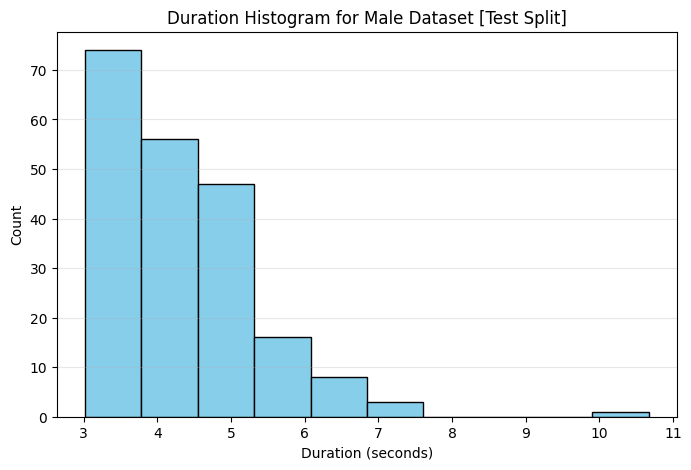

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(male_df_test['duration'], bins=10, color='skyblue', edgecolor='black')
plt.title('Duration Histogram for Male Dataset [Test Split]')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [31]:
# Count files in 0-10 seconds range and sum their total duration for male_df_train
mask_0_10_train = (male_df_train['duration'] > 0) & (male_df_train['duration'] <= 10)
count_0_10_train = mask_0_10_train.sum()
total_duration_0_10_train = male_df_train.loc[mask_0_10_train, 'duration'].sum()

print(f"Number of male TRAIN files with duration 0-10 seconds: {count_0_10_train}")
print(f"Total duration of these TRAIN files: {total_duration_0_10_train/3600:.2f} hrs")

# Count files in 0-10 seconds range and sum their total duration for male_df_test
mask_0_10_test = (male_df_test['duration'] > 0) & (male_df_test['duration'] <= 10)
count_0_10_test = mask_0_10_test.sum()
total_duration_0_10_test = male_df_test.loc[mask_0_10_test, 'duration'].sum()

print(f"Number of male TEST files with duration 0-10 seconds: {count_0_10_test}")
print(f"Total duration of these TEST files: {total_duration_0_10_test/3600:.2f} hrs")

Number of male TRAIN files with duration 0-10 seconds: 9489
Total duration of these TRAIN files: 11.13 hrs
Number of male TEST files with duration 0-10 seconds: 204
Total duration of these TEST files: 0.24 hrs


In [32]:
# Combine filtered train and test splits for male data and reset index
male_df_final = pd.concat([
    male_df_train[mask_0_10_train],
    male_df_test[mask_0_10_test]
], ignore_index=True)
male_df_final.reset_index(drop=True, inplace=True)

male_df_final

,text,file,sampling_rate,duration,split
0,.لِأَنَّهُ لَا يَرَى أَنَّهُ عَلَى السَّفَهِ ....,ch_20_arabic_tts_dataset_48,40100,5.29,train
1,.الْعُمْرُ .يَنْقُصُ وَالذُّنُوبُ تَزِيدُ,ch_05_arabic_tts_dataset_436,40100,3.06,train
2,.قَلِيلَةً بَيْنَ الْمُكْثِرِينَ .فَإِنَّ النَ...,ch_20_arabic_tts_dataset_20,40100,3.32,train
3,.إلَّا تَفَضُّلَا .وَمِنْهَا: الْعَقْلُ .الَّذ...,ch_16_arabic_tts_dataset_112,40100,5.08,train
4,.إلَّا مَثَلٌ مَرْذُولٌ .وَتَشْبِيهٌ .مَعْلُولٌ,ch_16_arabic_tts_dataset_554,40100,3.48,train
...,...,...,...,...,...
9688,.وَفِي يَدِهِ زِيَادَةً عَنْ كِفَايَتِهِ .فَيَ...,ch_11_arabic_tts_dataset_124,40100,4.85,test
9689,.بْنُ الْحَارِثِ الْهَاشِمِيُّ .تَحَرَّ مِنْ ا...,ch_16_arabic_tts_dataset_513,40100,3.38,test
9690,.كَالْمُتَغَلِّبِ .إذْ لَيْسَ فِي الْحُظُوظِ ت...,ch_18_arabic_tts_dataset_403,40100,3.36,test
9691,.وَمَنْ جَهِلَ مَوَاقِعَ الْحُقُوقِ وَمَقَادِي...,ch_11_arabic_tts_dataset_71,40100,4.59,test


## Phonemization of Arabic Text

In [54]:
import re
from phonemizer.backend import EspeakBackend
from phonemizer.punctuation import Punctuation

# Arabic diacritics Unicode range
arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]')

def remove_arabic_diacritics(text):
    return arabic_diacritics.sub('', text)

# Example usage:
backend = EspeakBackend(language='ar', preserve_punctuation=True,  with_stress=True)
punct = Punctuation("':()\"")  # Only remove ', :, (, ), and "
def phonemize_arabic_text_fast(text):
    text = punct.remove(text)
    return backend.phonemize([text], strip=True)[0]

sample = male_df_final.loc[0,'text']
print(sample)
print(phonemize_arabic_text_fast(sample))
print(remove_arabic_diacritics(sample))  # Output: العربية
print(phonemize_arabic_text_fast(remove_arabic_diacritics(sample)))

print('\n\n\n---------------------------------------------')
punct = Punctuation(';:,.!"?()-')
def phonemize_arabic_text_fast(text):
    text = punct.remove(text)
    return backend.phonemize([text], strip=True)[0]

sample = male_df_final.loc[0,'text']
print(sample)
print(phonemize_arabic_text_fast(sample))
print(remove_arabic_diacritics(sample))  # Output: العربية
print(phonemize_arabic_text_fast(remove_arabic_diacritics(sample)))


.لِأَنَّهُ لَا يَرَى أَنَّهُ عَلَى السَّفَهِ .ثُمَّ مِنْ بَعْدِ ذَلِكَ حَدِيثٌ مُنْتَشِرٌ
.liʔˌannhu laː jˈaraː ʔˈannhu ʕˈalaː ʔasssfˈahi .θˈumm mˈin baʕdˌi ðˈalikˌa ħˈadiːθˌun muntˈaʃirˌun
.لأنه لا يرى أنه على السفه .ثم من بعد ذلك حديث منتشر
.lʔnh lˈaː jrˈaː ʔnh ʕˈalaː ʔassˈafa .θˈumma mˈin bˈaʕd ðˈaːlikˌa ħˈadiːθ mˈuntaʃˌir



---------------------------------------------
.لِأَنَّهُ لَا يَرَى أَنَّهُ عَلَى السَّفَهِ .ثُمَّ مِنْ بَعْدِ ذَلِكَ حَدِيثٌ مُنْتَشِرٌ
liʔˌannhu laː jˈaraː ʔˈannhu ʕˈalaː ʔasssfˈahi θˈumm mˈin baʕdˌi ðˈalikˌa ħˈadiːθˌun muntˈaʃirˌun
.لأنه لا يرى أنه على السفه .ثم من بعد ذلك حديث منتشر
lʔnh lˈaː jrˈaː ʔnh ʕˈalaː ʔassˈafa θˈumma mˈin bˈaʕd ðˈaːlikˌa ħˈadiːθ mˈuntaʃˌir


In [67]:
from tqdm import tqdm
from phonemizer.backend import EspeakBackend
from phonemizer.punctuation import Punctuation

# Create backend once
backend = EspeakBackend(language='ar', preserve_punctuation=True,  with_stress=True)
# punct = Punctuation(';:,.!"?()-')
punct = Punctuation("':()\"")  # Only remove ', :, (, ), and "

def phonemize_arabic_text_fast(text):
    text = punct.remove(text)
    return backend.phonemize([text], strip=True)[0]

# Use tqdm with apply for progress bar
female_df_final = female_df_final.copy()
female_df_final['phonetic_text'] = list(
    tqdm(
        female_df_final['text'].apply(phonemize_arabic_text_fast),
        total=len(female_df_final),
        desc="Phonemizing female"
    )
)

male_df_final = male_df_final.copy()
male_df_final['phonetic_text'] = list(
    tqdm(
        male_df_final['text'].apply(phonemize_arabic_text_fast),
        total=len(male_df_final),
        desc="Phonemizing male"
    )
)

# Preview
print(female_df_final[['text', 'phonetic_text']].head())
print(male_df_final[['text', 'phonetic_text']].head())

Phonemizing male: 100%|██████████| 9693/9693 [00:00<00:00, 4352359.35it/s]

                                                text  \
0                    سُورَةُ الْأَحْزَابِ، الْآيَةُ    
1   يَكُنْ قَدْ وَضَعَ حَدًّا لَهُ، بَلْ حَضَّ عَ...   
2   وَلَمْ يَكُنْ الْمَسْعُودِيُّ وَاهِمًا فَذَاك...   
3   وَمِنْ هَذِهِ الإمبراطورية أَقَالِيمُ أَصْبَح...   
4   وَأَمَّا أَهْلُ الْمَقْتِ فَيُنَادَوْنَ عَلَى...   

                                       phonetic_text  
0                 suːrˌatu alʔˈaħzaːbˌi alʔaːˈiːatˌu  
1  jˈakun qˈad wˈadˤa.ʕˌa ħˈadːan lahˌu bal ħˈadˤ...  
2  wˈalam jˈakun almasʕˈuːdiːˌu wˈaːhimˌan faðˌaː...  
3  wˈamin hˈaðihˌi ʔalʔˌimbiraːt̪ˈuːriːjˌa ʔaqˈaː...  
4  wˈaʔammˌaː ʔˈahlu almˈaqti faˌiunˌaːdaˌuna ʕˈa...  
                                                text  \
0  .لِأَنَّهُ لَا يَرَى أَنَّهُ عَلَى السَّفَهِ ....   
1          .الْعُمْرُ .يَنْقُصُ وَالذُّنُوبُ تَزِيدُ   
2  .قَلِيلَةً بَيْنَ الْمُكْثِرِينَ .فَإِنَّ النَ...   
3  .إلَّا تَفَضُّلَا .وَمِنْهَا: الْعَقْلُ .الَّذ...   
4    .إلَّا مَثَلٌ مَرْذُولٌ .وَتَشْبِيهٌ .مَعْلُولٌ 

In [68]:
female_df_final

,text,file,sampling_rate,duration,split,phonetic_text,gender
0,سُورَةُ الْأَحْزَابِ، الْآيَةُ,female_6397,22100,2.80,train,suːrˌatu alʔˈaħzaːbˌi alʔaːˈiːatˌu,female
1,يَكُنْ قَدْ وَضَعَ حَدًّا لَهُ، بَلْ حَضَّ عَ...,female_8562,22100,11.03,train,jˈakun qˈad wˈadˤa.ʕˌa ħˈadːan lahˌu bal ħˈadˤ...,female
2,وَلَمْ يَكُنْ الْمَسْعُودِيُّ وَاهِمًا فَذَاك...,female_0811,22100,6.50,train,wˈalam jˈakun almasʕˈuːdiːˌu wˈaːhimˌan faðˌaː...,female
3,وَمِنْ هَذِهِ الإمبراطورية أَقَالِيمُ أَصْبَح...,female_0767,22100,13.22,train,wˈamin hˈaðihˌi ʔalʔˌimbiraːt̪ˈuːriːjˌa ʔaqˈaː...,female
4,وَأَمَّا أَهْلُ الْمَقْتِ فَيُنَادَوْنَ عَلَى...,female_6439,22100,16.43,train,wˈaʔammˌaː ʔˈahlu almˈaqti faˌiunˌaːdaˌuna ʕˈa...,female
...,...,...,...,...,...,...,...
3190,وَقَوْلُهُ تَعَالَى وَإِنَّ لَكُمْ فِي الْأَن...,female_6682,22100,12.26,test,wˌaqaˈuluhˌu tˈaʕaːlˌaː wˈaʔinnˌa lakˌum fiː a...,female
3191,وَهُوَ وَادٍ فَحْلٌ مِنْ أَوْدِيَةِ الْحِجَاز...,female_0960,22100,9.95,test,wˈahuːˌa wˈaːdin faħlˌun mˈin ʔˌaudˈiːatˌi alħ...,female
3192,وَهَذِهِ صِفَةٌ عَظِيمَةٌ فِي الثّباتِ وَالطّ...,female_2156,22100,11.06,test,wahˈaðihˌi s̪ˈi.fatˌun ʕaðˈi.ːmatˌun fiː ʔaθθθ...,female
3193,قُلْت يُعْرَفُ الْيَوْمَ بِأُجَيْرِدٍ تَصْغِي...,female_1176,22100,15.93,test,qˈult jˈuʕrafˌu aljˈaumˌa biʔˌudʒaˈiridˌin tˈa...,female


In [69]:
male_df_final

,text,file,sampling_rate,duration,split,phonetic_text,gender
0,.لِأَنَّهُ لَا يَرَى أَنَّهُ عَلَى السَّفَهِ ....,ch_20_arabic_tts_dataset_48,40100,5.29,train,.liʔˌannhu laː jˈaraː ʔˈannhu ʕˈalaː ʔasssfˈah...,male
1,.الْعُمْرُ .يَنْقُصُ وَالذُّنُوبُ تَزِيدُ,ch_05_arabic_tts_dataset_436,40100,3.06,train,.alʕˈumru .jˈanqus̪ˌu. waðˈuːnuːbˌu tˈaziːdˌu,male
2,.قَلِيلَةً بَيْنَ الْمُكْثِرِينَ .فَإِنَّ النَ...,ch_20_arabic_tts_dataset_20,40100,3.32,train,.qalˈiːlatˌan baˌina almukθˈiriːnˌa .faʔˌinn ʔ...,male
3,.إلَّا تَفَضُّلَا .وَمِنْهَا: الْعَقْلُ .الَّذ...,ch_16_arabic_tts_dataset_112,40100,5.08,train,.ʔllˈaː tafˈadˤu.ːlˌaː .wˈaminhˌaː alʕˈaqlu .a...,male
4,.إلَّا مَثَلٌ مَرْذُولٌ .وَتَشْبِيهٌ .مَعْلُولٌ,ch_16_arabic_tts_dataset_554,40100,3.48,train,.ʔllˈaː mˈaθalˌun mˈarðuːlˌun .watˈaʃbiːhˌun ....,male
...,...,...,...,...,...,...,...
9688,.وَفِي يَدِهِ زِيَادَةً عَنْ كِفَايَتِهِ .فَيَ...,ch_11_arabic_tts_dataset_124,40100,4.85,test,.wˈafiː jˈadihˌi ziːˈaːdatˌan ʕˈan kifˌaːjatˌi...,male
9689,.بْنُ الْحَارِثِ الْهَاشِمِيُّ .تَحَرَّ مِنْ ا...,ch_16_arabic_tts_dataset_513,40100,3.38,test,.bnˈu alħˈaːriθˌi alhaːʃˈimiːˌuː .tˈaħarr mˈin...,male
9690,.كَالْمُتَغَلِّبِ .إذْ لَيْسَ فِي الْحُظُوظِ ت...,ch_18_arabic_tts_dataset_403,40100,3.36,test,.kalmutˈaɣallbˌi .ʔð laˌisa fiː alħˈuðu.ːðˌi. ...,male
9691,.وَمَنْ جَهِلَ مَوَاقِعَ الْحُقُوقِ وَمَقَادِي...,ch_11_arabic_tts_dataset_71,40100,4.59,test,.wˈaman dʒˈahilˌa mˌauˈaːqiʕˌa alħˈuquːqˌi wˌa...,male


## Combining male and female Datasets

In [70]:
import pandas as pd

# Combine female and male DataFrames, add gender column
female_df_final = female_df_final.copy()
female_df_final['gender'] = 'female'

male_df_final = male_df_final.copy()
male_df_final['gender'] = 'male'

# Concatenate both DataFrames
combined_df = pd.concat([female_df_final, male_df_final], ignore_index=True)

# Split into train and test using the 'split' column
train_df_final = combined_df[combined_df['split'] == 'train'].reset_index(drop=True)
test_df_final = combined_df[combined_df['split'] == 'test'].reset_index(drop=True)

print("Train set shape:", train_df_final.shape)
print("Test set shape:", test_df_final.shape)
print(train_df_final[['file', 'gender', 'split', 'phonetic_text']].head())
print(test_df_final[['file', 'gender', 'split', 'phonetic_text']].head())

Train set shape: (12620, 7)
Test set shape: (268, 7)
          file  gender  split  \
0  female_6397  female  train   
1  female_8562  female  train   
2  female_0811  female  train   
3  female_0767  female  train   
4  female_6439  female  train   

                                       phonetic_text  
0                 suːrˌatu alʔˈaħzaːbˌi alʔaːˈiːatˌu  
1  jˈakun qˈad wˈadˤa.ʕˌa ħˈadːan lahˌu bal ħˈadˤ...  
2  wˈalam jˈakun almasʕˈuːdiːˌu wˈaːhimˌan faðˌaː...  
3  wˈamin hˈaðihˌi ʔalʔˌimbiraːt̪ˈuːriːjˌa ʔaqˈaː...  
4  wˈaʔammˌaː ʔˈahlu almˈaqti faˌiunˌaːdaˌuna ʕˈa...  
          file  gender split  \
0  female_0744  female  test   
1  female_0140  female  test   
2  female_1467  female  test   
3  female_0043  female  test   
4  female_2346  female  test   

                                       phonetic_text  
0  qˈult laː zˈaːlat tˈuʕrafˌu fiː rˈaʔsi wˈaːdiː...  
1  ða.nˈiːnukˌa munʃˈaɣilˌun biaːdːˈauˌaːhiː ʔˌaʔ...  
2  wˈakaːnˌa qˈadiːmˌan liɣˌifaːrˌi mˈin kinˌaːna...  
3  jˈ

In [71]:
import os
from datasets import Dataset, DatasetDict, Audio
from tqdm import tqdm

def build_hf_row_from_wav(row, output_dir):
    if row['gender'] == 'female':
        wav_name = f"{row['file']}.wav"
        # Link to original female dataset
        source = "https://huggingface.co/datasets/Nourhann/Arabic-Diacritized-TTS"
    else:
        wav_name = f"{row.get('original_file', row['file'])}.wav"
        # Link to original male dataset
        source = "https://huggingface.co/datasets/MBZUAI/ClArTTS"
    wav_path = os.path.join(output_dir, wav_name)
    return {
        "text": row['text'],
        "phonetic_text": row['phonetic_text'],
        "source": source,
        "file": row['file'],
        "audio": wav_path,
        "gender": row['gender'],
        "sampling_rate": 24000,
        "duration": row['duration'],
    }
output_dir = "wav_data"
column_order = ['text', 'phonetic_text', 'source', 'file', 'audio', 'gender', 'sampling_rate', 'duration']

train_rows = [
    build_hf_row_from_wav(row, output_dir)
    for _, row in tqdm(train_df_final.iterrows(), total=len(train_df_final), desc="Building train dataset")
]
test_rows = [
    build_hf_row_from_wav(row, output_dir)
    for _, row in tqdm(test_df_final.iterrows(), total=len(test_df_final), desc="Building test dataset")
]

# Ensure column order
train_hf = Dataset.from_list([{k: row[k] for k in column_order} for row in train_rows]).cast_column("audio", Audio(sampling_rate=24000))
test_hf = Dataset.from_list([{k: row[k] for k in column_order} for row in test_rows]).cast_column("audio", Audio(sampling_rate=24000))

final_ds = DatasetDict({"train": train_hf, "test": test_hf})

print(final_ds)
print(final_ds["train"][0])

Building test dataset: 100%|██████████| 268/268 [00:00<00:00, 41824.43it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'phonetic_text', 'source', 'file', 'audio', 'gender', 'sampling_rate', 'duration'],
        num_rows: 12620
    })
    test: Dataset({
        features: ['text', 'phonetic_text', 'source', 'file', 'audio', 'gender', 'sampling_rate', 'duration'],
        num_rows: 268
    })
})
{'text': ' سُورَةُ الْأَحْزَابِ، الْآيَةُ ', 'phonetic_text': 'suːrˌatu alʔˈaħzaːbˌi alʔaːˈiːatˌu', 'source': 'https://huggingface.co/datasets/Nourhann/Arabic-Diacritized-TTS', 'file': 'female_6397', 'audio': {'path': 'wav_data/female_6397.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00, -3.05175781e-05, ...,
       -3.05175781e-05,  0.00000000e+00, -3.05175781e-05], shape=(67240,)), 'sampling_rate': 24000}, 'gender': 'female', 'sampling_rate': 24000, 'duration': 2.8}


In [72]:
from huggingface_hub import notebook_login
from datasets import DatasetDict

# Log in to Hugging Face Hub (will prompt for your token)
notebook_login()

# Push the dataset to your Hugging Face account
final_ds.push_to_hub("NeoBoy/arabic-tts-wav-24k")

Uploading the dataset shards:   0%|          | 0/11 [00:00<?, ?it/s]

Map:   0%|          | 0/1148 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1148 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1148 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/NeoBoy/arabic-tts-wav-24k/commit/42c35408512d5d2af3958686185499a682321f71', commit_message='Upload dataset', commit_description='', oid='42c35408512d5d2af3958686185499a682321f71', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/NeoBoy/arabic-tts-wav-24k', endpoint='https://huggingface.co', repo_type='dataset', repo_id='NeoBoy/arabic-tts-wav-24k'), pr_revision=None, pr_num=None)